Simulate Hamiltonian time evolution using Trotterization method on cc & qc  
Last Modified by JungYoung Kim, 2021-06-30

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.opflow import I,X,Y,Z,CX,H,Zero,StateFn,PauliTrotterEvolution,PauliExpectation,Suzuki,One,CircuitSampler
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, transpile, assemble
from qiskit.visualization import plot_histogram

In [79]:
from qiskit import IBMQ
IBMQ.save_account('fdfb80d19410419eff8c7cbef32c13fba8d3ac8c39289eb504936d5bcf71307dd8ca5c7aa2f6790d054889f46d11d70ea2b4994a4d2a7003c8a4cd6f759bbb63', overwrite = True )

In [80]:
from qiskit.providers.ibmq import least_busy

# check available backends
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-skku', group='skku', project='saint')
# print("Avaliable backends:")
# provider.backends()
large_enough_devices = provider.backends(filters=lambda x: x.configuration().n_qubits > 2 and not x.configuration().simulator)
backend = least_busy(large_enough_devices)
print('the best backend is  : '+ backend.name())

ibmqfactory.load_account:WARNING:2021-07-01 17:05:26,410: Credentials are already in use. The existing account in the session will be replaced.


the best backend is  : ibmq_guadalupe


In [81]:
plt.rcParams['font.family'] = 'Serif'
plt.rcParams['font.size'] = 10

In [82]:
def evolv_operator(two_qubit_h, init_state, t_pts, is_c=True, backend=None, order=1, reps=1):
    
    t_obj = Parameter('t')
    evolv_op = (t_obj * two_qubit_h).exp_i()
    # Measure - Z
    Z1 = StateFn(Z^I).adjoint()
    # operator
    op = Z1 @ evolv_op @ init_state
    # Using Trotterization operator - order=1, reps=1
    trot_op = PauliTrotterEvolution(Suzuki(order=order, reps=reps)).convert(op)
    diag_trot_op = PauliExpectation().convert(trot_op)

    bounds = diag_trot_op.bind_parameters({t_obj: list(t_pts)})

    if is_c:
        y = bounds.eval()
    else:
        sampler = CircuitSampler(backend=backend)
        exp = sampler.convert(bounds)
        y = exp.eval()
    
    return y, trot_op


def get_error(x,y,xq,yq):
    # rq: qc points
    x = np.array(x)
    xq = np.array(xq)

    errs = []
    for i in range(len(xq)):
        n = np.argmin(np.abs(x-xq[i]))
        errs.append(yq[i]-y[n])
    return errs

## Only exchange interaction exists

In [83]:
# Create initial state
v = np.random.uniform(size=4)
v = v/np.sqrt(sum(v**2))
# init_state = StateFn(v)

v = [0.175, 0.04, 0.736, 0.653]
init_state = StateFn(v)

print(v)

[0.175, 0.04, 0.736, 0.653]


/home/jungyoung/.local/lib/python3.6/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)


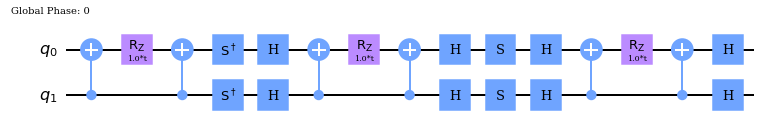

In [84]:
H_no_field = (0.5*X^X) + (0.5*Y^Y) + (0.5*Z^Z)

# set time range
t0, t1 = 0, 5

# evolving
t_pts_cc = np.linspace(t0, t1, 1000)
t_pts_qc = np.linspace(t0, t1, 50)

y_cc1, trot_op1 = evolv_operator(H_no_field, init_state, t_pts_cc)
y_qc1, _ = evolv_operator(H_no_field, init_state, t_pts_qc, is_c=False, backend=backend)
trot_op1[1].to_circuit().draw('mpl')

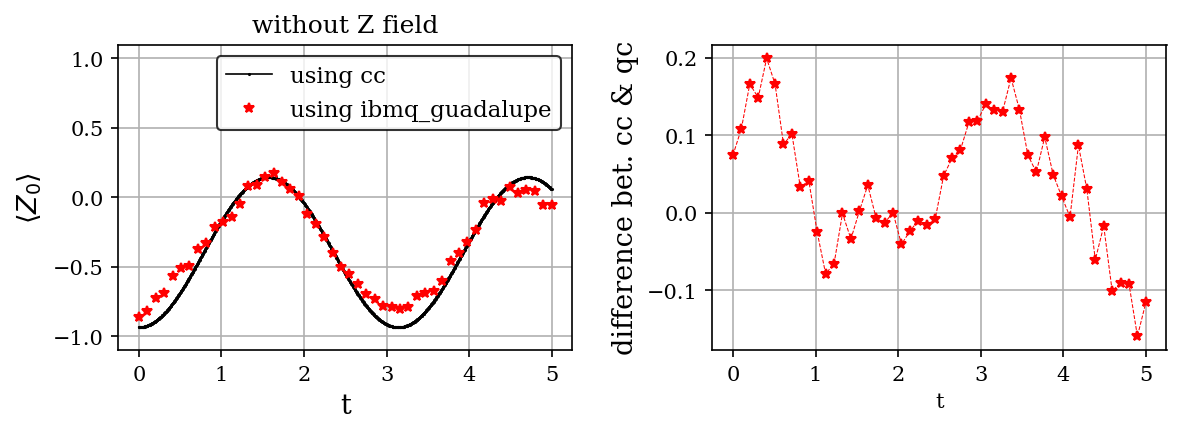

In [85]:
errs = get_error(t_pts_cc, y_cc1, t_pts_qc, y_qc1)

plt.figure(dpi=150, figsize=(8, 3))
plt.subplot(121)
plt.plot(t_pts_cc, np.real(y_cc1), 'k.-', ms=1, lw=0.8, label='using cc')
plt.plot(t_pts_qc, np.real(y_qc1), 'r*', ms=5, label='using %s'%(backend.name()))
plt.legend(loc=1, edgecolor='k', fontsize=11, framealpha=0.8)
plt.grid(True)
plt.xlabel('t', fontsize=13)
plt.ylabel(r'$\langle Z_{0} \rangle$', fontsize=13)
plt.ylim([-1.1, 1.1])
plt.title('without Z field', fontsize=12)

plt.subplot(122)
plt.plot(t_pts_qc, errs, 'r*--', ms=5, lw=0.5)
plt.xlabel('t')
plt.ylabel('difference bet. cc & qc', fontsize=13)
plt.grid(True)

# plt.suptitle('without Z field', fontsize=12)
plt.tight_layout()
plt.show()

## Exchange interaction with Z field

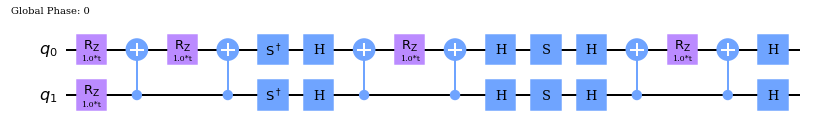

In [86]:
H_with_field = (0.5*X^X) + (0.5*Y^Y) + (0.5*Z^Z)  + (0.5*Z^I) + (0.5*I^Z)

# evolving
t_pts_cc = np.linspace(t0, t1, 1000)
t_pts_qc = np.linspace(t0, t1, 50)

y_cc2, trot_op2 = evolv_operator(H_with_field, init_state, t_pts_cc)
y_qc2,_ = evolv_operator(H_with_field, init_state, t_pts_qc, is_c=False, backend=backend)

trot_op2[1].to_circuit().draw('mpl')

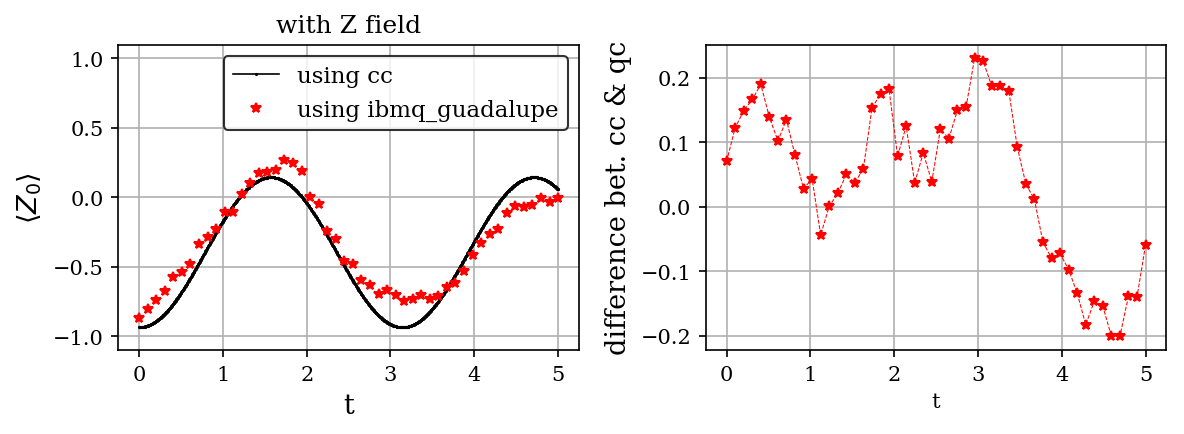

In [87]:
errs = get_error(t_pts_cc, y_cc2, t_pts_qc, y_qc2)

plt.figure(dpi=150, figsize=(8, 3))
plt.subplot(121)
plt.plot(t_pts_cc, np.real(y_cc2), 'k.-', ms=1, lw=0.8, label='using cc')
plt.plot(t_pts_qc, np.real(y_qc2), 'r*', ms=5, label='using %s'%(backend.name()))
plt.legend(loc=1, edgecolor='k', fontsize=11, framealpha=0.8)
plt.grid(True)
plt.xlabel('t', fontsize=13)
plt.ylabel(r'$\langle Z_{0} \rangle$', fontsize=13)
plt.ylim([-1.1, 1.1])
plt.title('with Z field', fontsize=12)

plt.subplot(122)
plt.plot(t_pts_qc, errs, 'r*--', ms=5, lw=0.5)
plt.xlabel('t')
plt.ylabel('difference bet. cc & qc', fontsize=13)
plt.grid(True)

plt.tight_layout()
plt.show()

In [55]:
y_qc_o1, _ = evolv_operator(H_no_field, init_state, t_pts_qc, is_c=False, backend=backend, order=1)
y_qc_o2, _ = evolv_operator(H_no_field, init_state, t_pts_qc, is_c=False, backend=backend, order=2)
y_qc_o3, _ = evolv_operator(H_no_field, init_state, t_pts_qc, is_c=False, backend=backend, order=2)
y_qc_r1, _ = evolv_operator(H_no_field, init_state, t_pts_qc, is_c=False, backend=backend, reps=1, order=1)
y_qc_r2, _ = evolv_operator(H_no_field, init_state, t_pts_qc, is_c=False, backend=backend, reps=2, order=1)
y_qc_r3, _ = evolv_operator(H_no_field, init_state, t_pts_qc, is_c=False, backend=backend, reps=3, order=1)

(-1.1, 1.1)

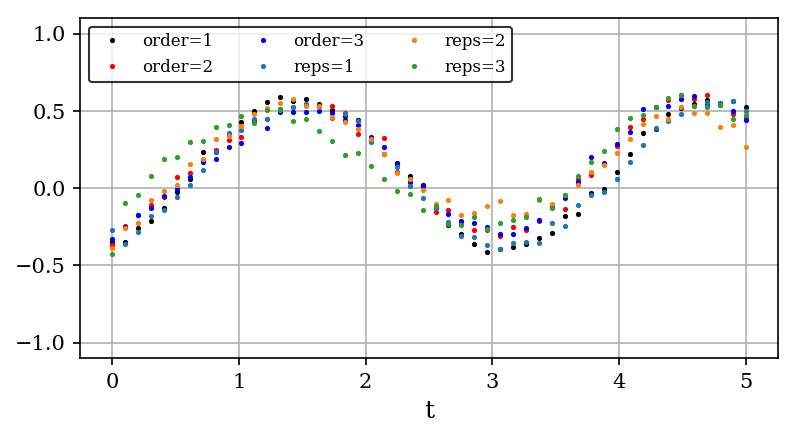

In [39]:
plt.figure(dpi=150, figsize=(6, 3))
plt.plot(t_pts_qc, y_qc_o1, 'k.', label='order=1', ms=3)
plt.plot(t_pts_qc, y_qc_o2, 'r.', label='order=2', ms=3)
plt.plot(t_pts_qc, y_qc_o3, 'b.', label='order=3', ms=3)

plt.plot(t_pts_qc, y_qc_r1, '.', label='reps=1', ms=3)
plt.plot(t_pts_qc, y_qc_r2, '.', label='reps=2', ms=3)
plt.plot(t_pts_qc, y_qc_r3, '.', label='reps=3', ms=3)

plt.legend(loc=2, ncol=3, fontsize=8, edgecolor='k', framealpha=0.8)
plt.grid(True)
plt.xlabel('t', fontsize=12)

plt.ylim([-1.1, 1.1])

## Failed simulation

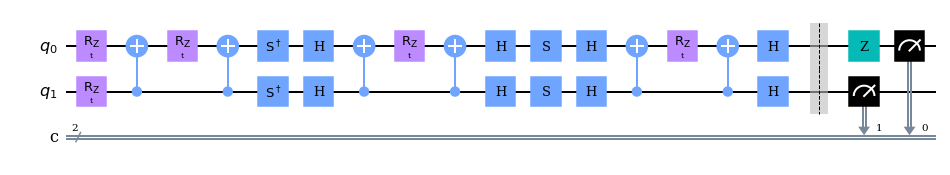

In [11]:
# Create Quantum circuit for Trotterization
t_obj = Parameter('t')

qreg_q = QuantumRegister(2, 'q')
creg_c = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

# Z field
circuit.rz(t_obj, 0)
circuit.rz(t_obj, 1)
# Z
circuit.cx(1, 0)
circuit.rz(t_obj, 0)
circuit.cx(1, 0)
# Y
circuit.sdg(0)
circuit.sdg(1)
circuit.h(0)
circuit.h(1)
circuit.cx(1, 0)
circuit.rz(t_obj, 0)
circuit.cx(1, 0)
circuit.h(0)
circuit.h(1)
circuit.s(0)
circuit.s(1)
# X
circuit.h(0)
circuit.h(1)
circuit.cx(1, 0)
circuit.rz(t_obj, 0)
circuit.cx(1, 0)
circuit.h(0)
circuit.h(1)

circuit.barrier()

# circuit.z(0)
# measurement
circuit.z(0)
circuit.measure(0, 0)
circuit.measure(1, 1)

circuit.draw('mpl')

In [12]:
# Create initial state
v = np.random.uniform(size=4)
v = v/np.sqrt(sum(v**2))
init_state = StateFn(v)

In [13]:
# Run job on the qc
t_pts = np.linspace(0,0.5,10)
# job = execute(circuit, backend=backend, parameter_binds=[{t_obj:t} for t in t_pts], shots=8192)
job = execute(circuit, backend=backend, parameter_binds=[{t_obj:t} for t in t_pts], shots=8192)
counts = job.result().get_counts()
# get <Z>
nshots = 8192
y_qc = []
for i in range(len(counts)):
    c = counts[i]
    y = (c['00']+c['01']-c['10']-c['11'])/nshots
    y_qc.append(y)

NameError: name 'qc' is not defined